Omicron variant dominant, 
December 25 2021 - Current 

https://www.cdc.gov/mmwr/volumes/71/wr/mm7109e1.htm#:~:text=The%20B.1.1.529%20(,%E2%80%93January%202022%20(1).

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [164]:
# !pip install PyTorch
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [165]:
Omicron_2021Dec2022Mar_rawPostData = pd.read_csv('./Rcode/Reddit_post_202112_202203.csv', encoding='cp1252')
Omicron_2021Dec2022Mar_rawCommentData = pd.read_csv('./Rcode/Reddit_comment_202112_202203.csv', encoding='cp1252') 
Omicron_2021Dec2022Mar_rawData = pd.concat([Omicron_2021Dec2022Mar_rawPostData, 
                                            Omicron_2021Dec2022Mar_rawCommentData],axis=0)
Omicron_2021Dec2022Mar_rawData = Omicron_2021Dec2022Mar_rawData.sort_values(by=['author', 'created_utc'])#sort by time
Omicron_2021Dec2022Mar_rawData = Omicron_2021Dec2022Mar_rawData.reset_index(drop=True)
Omicron_2021Dec2022Mar_rawData

,author,created_utc,num_comments,permalink,body,title,link_flair_text,file_code
0,---rayne---,2021-12-28 19:34:49,0,/r/COVID19positive/comments/rq8agu/unvaxxed_wi...,Sorry you cant get the vax. I suggest getting ...,comment,comment,327
1,--FuckYouSpez--,2021-12-15 14:20:03,0,/r/COVID19positive/comments/rgzzar/my_parents_...,"Given they are vaccinated, they are still like...",comment,comment,10
2,--FuckYouSpez--,2021-12-15 14:23:13,0,/r/COVID19positive/comments/rgw85u/need_some_a...,"Get a pulse oximeter, monitor your blood oxyge...",comment,comment,10
3,--FuckYouSpez--,2021-12-15 14:25:07,0,/r/COVID19positive/comments/rh07jq/continued_p...,"Under CDC guidance, she is free of isolation o...",comment,comment,10
4,--FuckYouSpez--,2021-12-15 14:40:44,0,/r/COVID19positive/comments/rgx97s/3_lateral_f...,Symptoms plus multiple positive tests means yo...,comment,comment,10
...,...,...,...,...,...,...,...,...
132032,zzcczzcc,2022-01-18 00:37:13,0,/r/COVID19positive/comments/s6i352/having_had_...,"Honestly, it feels more like Chutes and Ladders.",comment,comment,812
132033,zzcczzcc,2022-01-20 06:01:47,0,/r/COVID19positive/comments/s7gkto/psa_for_tho...,Air purifier with HEPA filter\r\nFans\r\nExtra...,comment,comment,866
132034,zzcczzcc,2022-01-29 12:50:42,0,/r/COVID19positive/comments/sf6nv6/anxiety_pan...,"I had the same thing, where it felt like every...",comment,comment,1088
132035,zzzrpm,2021-12-27 20:44:46,0,/r/COVID19positive/comments/rp97la/this_covid_...,2x vaxxed\r\n\r\nthird pfizer shot was about 5...,comment,comment,304


### Combine title and body

In [166]:
import re
author = Omicron_2021Dec2022Mar_rawData[['author']].author.values
body_sentences = Omicron_2021Dec2022Mar_rawData[['body']].body.values
title = Omicron_2021Dec2022Mar_rawData[['title']].title.values
created_utc = Omicron_2021Dec2022Mar_rawData[['created_utc']].created_utc.values


title_body_sentences, author_cleaned, body_sentences_cleaned, title_cleaned, created_utc_cleaned= [], [], [], [], []
for i in range(len(body_sentences)):
    if type(body_sentences[i]) != str:
        body_sentences[i] = str(body_sentences[i])
    if len(body_sentences[i].split()) <= 3:  #remove body with less than one word
        continue
    body_sentences[i] = body_sentences[i].replace('_x000D_',' ').replace('\r', '').replace('\n', '').replace('  ','').replace('[removed]','').replace("\'","'").replace('&amp;','&')
    body_sentences[i] = re.sub(r'http\S+', '', body_sentences[i]) #remove website http:
    body_sentences[i] = re.sub(r'\<U\+[A-Za-z0-9]+\>','', body_sentences[i]) #remove emoji
    body_sentences_cleaned.append(body_sentences[i])
    title_cleaned.append(title[i])
    title_body_sentences.append(title[i] + ": " + body_sentences[i])
    author_cleaned.append(author[i])
    created_utc_cleaned.append(created_utc[i])

cleaned_temp_data = pd.DataFrame() #record for later using to create positive dataframe
cleaned_temp_data['author'] = author_cleaned
cleaned_temp_data['body'] = body_sentences_cleaned
cleaned_temp_data['title'] = title_cleaned
cleaned_temp_data['created_utc'] = created_utc_cleaned

temp_data = pd.DataFrame()
temp_data['author'] = author_cleaned 
temp_data['title_body_sentences'] = title_body_sentences 
temp_data['title_body'] = temp_data.groupby(['author'])['title_body_sentences'].transform(lambda x: '. '.join(x))

final_data = temp_data[['author','title_body']]
final_data = final_data.drop_duplicates()
final_data = final_data.reset_index(drop=True)
final_data 

,author,title_body
0,---rayne---,comment: Sorry you cant get the vax. I suggest...
1,--FuckYouSpez--,"comment: Given they are vaccinated, they are s..."
2,--GA--,"257 days: 257 days since infection- Brain Fog,..."
3,--Gungnir--,"comment: It's NOT a ""bacterial menace""..As you..."
4,--ozzy--,comment: For me it went away after day 6
...,...,...
24163,zyreux,"My mother 52F has tested positive today, she’s..."
24164,zz-de,My sister is so inconsiderate and I want to cr...
24165,zzDeathGodzz,comment: I got Thrombocytopenia (ITP) from my ...
24166,zzcczzcc,comment: I’ve lost my sense of smell twice bef...


In [21]:
all_words_len= [] #record length
# For every sentence...
for sent in final_data['title_body']:
    all_words_len.append(len(sent.split()))
print('Max sentence length (for words): ', max(all_words_len))   
print('Min sentence length (for words): ', min(all_words_len))  
print('0.25, 0.5, 0.75, and 0.95 Quantile sentence length (for words):', np.quantile(all_words_len,[0.25, 0.5, 0.75, 0.95]) ) 


Max sentence length (for words):  664347
Min sentence length (for words):  4
0.25, 0.5, 0.75, and 0.95 Quantile sentence length (for words): [ 42.   100.   236.   858.65]


### Prepare test data

In [167]:
MAX_LEN = 512

In [136]:
import numpy as np
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case = True)
input_ids = []    # chunks embedding ID 
author_names = final_data['author'].to_numpy()  # Get the author names from the dataset.

chunk_author = [] # Record author names for chunks 
chunk_nums = []   # Record number of chunks for each author

print('Tokenizing comments...')
# For every sentence...
for i, sen in enumerate(final_data['title_body']):
    if ((len(input_ids) % 1000) == 0):
        print('Read {:,} comments.'.format(len(input_ids)))

    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        #max_length = 512,          # Truncate all sentences.                        
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   ) 
    author_i = author_names[i]

    if len(encoded_sent) > MAX_LEN:   #For long document, chunk it
        encoded_sent = encoded_sent[1:-1]   # Strip off special tokens.
        chunk_len = MAX_LEN - 2             # each chunk needs its own CLS and SEP tokens.
        chunk_nums.append(len(range(0, len(encoded_sent), chunk_len))) ### add number of chunks for each author
        # For each starting index...
        for j in range(0, len(encoded_sent), chunk_len):
            tokens = encoded_sent[j:j+chunk_len]
            chunk = [tokenizer.cls_token_id] + tokens + [tokenizer.sep_token_id]   # Add the special tokens.
            input_ids.append(chunk)
            chunk_author.append(author_i)   # Give all the chunks the same author names. 
    
    else:    #For short document, add it to the list.
        chunk_nums.append(1) ### add number of chunks for each author
        input_ids.append(encoded_sent)
        chunk_author.append(author_i)   

print('DONE.')
print('{:>10,} documents before chunking'.format(len(final_data)))
print('{:>10,} comments after chunking'.format(len(input_ids)))
print('{:>10,} length of each chunk'.format(MAX_LEN))


Token indices sequence length is longer than the specified maximum sequence length for this model (4944 > 512). Running this sequence through the model will result in indexing errors


Tokenizing comments...
Read 0 comments.
Read 1,000 comments.
Read 4,000 comments.
Read 5,000 comments.
Read 6,000 comments.
Read 7,000 comments.
Read 8,000 comments.
Read 9,000 comments.
Read 10,000 comments.
Read 12,000 comments.
Read 13,000 comments.
Read 14,000 comments.
Read 17,000 comments.
Read 18,000 comments.
Read 19,000 comments.
Read 21,000 comments.
Read 23,000 comments.
Read 24,000 comments.
Read 25,000 comments.
Read 26,000 comments.
Read 27,000 comments.
Read 28,000 comments.
Read 29,000 comments.
Read 30,000 comments.
Read 31,000 comments.
Read 32,000 comments.
Read 33,000 comments.
Read 34,000 comments.
DONE.
    24,168 documents before chunking
    34,337 comments after chunking
       512 length of each chunk


### Pad chunks and Add Attention Masks

In [21]:
# Some of the samples need to be padded out to 128 tokens 
from keras.preprocessing.sequence import pad_sequences
print('Padding/truncating all chunks to %d values...' % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
# Pad input tokens with value 0.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
print('{:>10,} chunks in total'.format(len(input_ids)))

# Create attention masks for each chunk
attention_masks = []
for chu in input_ids:
    att_mask = [int(token_id > 0) for token_id in chu]
    attention_masks.append(att_mask)
print('{:>10,} attention masks in total'.format(len(attention_masks)))
print('{:>10,} length for each attention mask'.format(len(attention_masks[0])))

Padding/truncating all chunks to 512 values...
Padding token: "[PAD]", ID: 0


Using TensorFlow backend.


    34,116 chunks in total
    34,116 attention masks in total
       512 length for each attention mask


### Obtain test input

In [22]:
test_authors_set = set(final_data['author'])
test_inputs, test_labels, test_masks, test_chunk_author  = [], [], [], []
for i in range(len(input_ids)):
    test_inputs.append(input_ids[i])
    test_masks.append(attention_masks[i])  
    test_chunk_author.append(chunk_author[i])
test_inputs = np.array(test_inputs)
print('test data has %d authors, %d chunks'%(len(test_authors_set), len(test_inputs)))

test data has 24168 authors, 34116 chunks


### Dictionary mapping authors to chunk index

In [30]:
test_author_ind_dic ={}
for i in range(len(test_chunk_author)):
    Author = test_chunk_author[i]
    if Author not in test_author_ind_dic: 
      test_author_ind_dic[Author] = [i]
    else:
      test_author_ind_dic[Author].append(i)
print('test dictionary has %d authors'%(len(test_author_ind_dic)))

test dictionary has 24168 authors


### Convert all inputs into torch tensors

In [29]:
import torch
test_inputs = torch.tensor(test_inputs)
test_masks = torch.tensor(test_masks)

/Users/muzheguo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/muzheguo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


### Create an iterator for the dataset using the torch DataLoader class. (help save on memory during training)

In [27]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32
# Create the DataLoader for test set.
test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [23]:
import time
import datetime
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Prediction on test dataset on GWU HPC

In [ ]:
# Prediction on test dataset
<prevent running>
from transformers import BertForSequenceClassification, AdamW, BertConfig
output_dir = './output_files/BERTlarge_CLS2_model_chunk512_epoch2' + '/' 
model_chuncking = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = tokenizer.from_pretrained(output_dir)
model_chuncking.to(device)  # Copy the model to the GPU.

print('Predicting labels for {:,} test chunks...'.format(len(test_inputs)))
model_chuncking.eval()
predictions  = []

t0 = time.time()
for (step, batch) in enumerate(test_dataloader):

  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Progress update every 100 batches.
  if step % 100 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

  # Unpack the inputs from dataloader
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model_chuncking(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  predictions.append(logits)

print('------DONE.------')
predictions = np.concatenate(predictions, axis=0)

#save the predictions:
#np.savetxt('./output_files/BERTlarge_CLS2_model_chunk512/Omicron_variant_2021Dec2022Mar/Omicron_variant_2021Dec2022Mar.txt', predictions)


### Read the prediction values and normalize them

In [137]:
#read 
Omicron_variant_2021Dec2022Mar_classPred = np.loadtxt('./output_files/BERTlarge_CLS2_model_chunk512/Omicron_variant_2021Dec2022Mar/Omicron_variant_2021Dec2022Mar.txt', dtype=float)
Omicron_variant_2021Dec2022Mar_classPred = torch.tensor(Omicron_variant_2021Dec2022Mar_classPred)
Omicron_variant_2021Dec2022Mar_classPred = (Omicron_variant_2021Dec2022Mar_classPred-Omicron_variant_2021Dec2022Mar_classPred.min(0, keepdim=True).values)/(Omicron_variant_2021Dec2022Mar_classPred.max(0, keepdim=True).values - Omicron_variant_2021Dec2022Mar_classPred.min(0, keepdim=True).values)
Omicron_variant_2021Dec2022Mar_classPred.shape


torch.Size([34337, 2])

### Read the trained weights

In [40]:
trained_W0 = torch.tensor(np.loadtxt('./output_files/BERTlarge_CLS2_model_chunk512/trained_W0.txt'),dtype=torch.float32)
trained_W1 = torch.tensor(np.loadtxt('./output_files/BERTlarge_CLS2_model_chunk512/trained_W1.txt'),dtype=torch.float32)

### original chunk scores and zero-pad chunk scores

In [41]:
max_chunk_nums = 100  #max chunk number, if larger than this, truncate it. 
test_chunks_scores = []
for Author in final_data['author']:
    chunk_indeces = test_author_ind_dic[Author]
    if len(chunk_indeces) <= max_chunk_nums:
      chunks_outputs = Omicron_variant_2021Dec2022Mar_classPred[chunk_indeces, :]
    if len(chunk_indeces) > max_chunk_nums:
      chunks_outputs = Omicron_variant_2021Dec2022Mar_classPred[chunk_indeces[0:max_chunk_nums], :]
    test_chunks_scores.append(chunks_outputs)

### zero-pad chunk scores
test_chunks_pad_scores = []
for i in range(len(test_chunks_scores)):
    zero_pad = np.zeros( (max_chunk_nums -len(test_chunks_scores[i]), 2))
    pad_score = np.vstack((test_chunks_scores[i], zero_pad))
    test_chunks_pad_scores.append(pad_score)
test_chunks_pad_scores = torch.tensor(np.array(test_chunks_pad_scores),dtype=torch.float)  #(544,495,4)
print('test_chunks_pad_scores:',test_chunks_pad_scores.shape)

test_chunks_pad_scores: torch.Size([24168, 100, 2])


### time weight and weighted scores

In [42]:
test_h0 = trained_W0.t().matmul(test_chunks_pad_scores)
weighted_test_scores = trained_W1.t().matmul(test_h0).reshape(2,-1)
weighted_test_scores = weighted_test_scores.detach().numpy() # convert torch.tensor to array
weighted_test_scores.shape

(2, 24168)

there are 12094 authors are predicted positive.


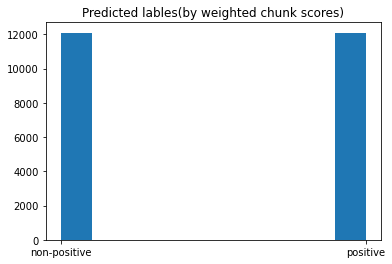

In [43]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
weighted_labels = np.argmax(weighted_test_scores, axis=0)
weighted_labels_text = [['non-positive','positive'][weighted_labels[i] ] for i in range(len(weighted_labels))]
plt.hist(weighted_labels_text)
plt.title('Predicted lables(by weighted chunk scores)')
print('there are %d authors are predicted positive.'  %sum(weighted_labels))

### Get positive data 2021Dec-2022Mar

In [139]:
import re
final_data['pred_class'] = weighted_labels #add predicted label to final_data
positive_data2021Dec2022Mar= final_data[['author','pred_class']].merge(cleaned_temp_data, 
                                                        left_on='author', right_on='author',how='left')
positive_data2021Dec2022Mar = positive_data2021Dec2022Mar[positive_data2021Dec2022Mar['pred_class']==1]
#positive_data2021Dec2022Mar.to_csv('./output_files/2021Dec2022Mar/positive_data2021Dec2022Mar.csv',index=False, encoding='utf_8_sig')


### Read positive data 2021 Dec -2022 March

In [168]:
positive_data2021Dec2022Mar = pd.read_csv('./output_files/2021Dec2022Mar/positive_data2021Dec2022Mar.csv')
#convert author, body, and title to string 
positive_data2021Dec2022Mar = positive_data2021Dec2022Mar.astype({'author':'string','body':'string','title':'string'})
positive_data2021Dec2022Mar = positive_data2021Dec2022Mar.dropna() 
print("%d positive authors"%len(set(positive_data2021Dec2022Mar.author)))
positive_data2021Dec2022Mar

12094 positive authors


,author,pred_class,body,title,created_utc
0,-01101101-,1,on my info sheet it said to throw away swab an...,comment,2022-01-18 00:42:47
1,-1911-,1,I had covid about 4 months ago and the problem...,comment,2022-01-21 21:31:15
2,-1911-,1,You are most definitely over reacting. If you ...,comment,2022-01-24 21:21:15
3,-Boy-Mom,1,My nose just. Isn’t working. Negative tests. I...,comment,2021-12-22 03:36:39
4,-CryptoSardine-,1,Hey are you feeling better ?,comment,2022-01-01 01:51:27
...,...,...,...,...,...
56020,zzcczzcc,1,"Sounds like it could be congestion, if you can...",comment,2022-01-16 01:19:50
56021,zzcczzcc,1,"Oh yes! For me, whenever I have a cold, there’...",comment,2022-01-16 13:35:52
56022,zzcczzcc,1,"Honestly, it feels more like Chutes and Ladders.",comment,2022-01-18 00:37:13
56023,zzcczzcc,1,Air purifier with HEPA filterFansExtra quilts ...,comment,2022-01-20 06:01:47


## NLP extraction

In [25]:
from datasets import load_dataset, load_metric
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import BertForQuestionAnswering,BertTokenizer,BertModel,AutoTokenizer # AdamW, BertConfig
bert_large_finetuned_model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
biobert_large_finetuned_model = BertForQuestionAnswering.from_pretrained('dmis-lab/biobert-large-cased-v1.1-squad')
tokenizer_large = AutoTokenizer.from_pretrained('bert-large-uncased')
tokenizer_biobert_large = AutoTokenizer.from_pretrained('dmis-lab/biobert-large-cased-v1.1-squad')
positive_len_bert, positive_len_biobert = [],[] #record length

args_large = TrainingArguments(
    f"test-squad",
    evaluation_strategy = "epoch",
    learning_rate= 3e-5,  
    per_device_train_batch_size = 16,  
    per_device_eval_batch_size= 16,   
    num_train_epochs= 2, 
    weight_decay=0.01)
trainer_large_BERT = Trainer(
    bert_large_finetuned_model,
    args_large,
    #train_dataset=tokenized_datasets["train"],
    #eval_dataset=tokenized_datasets["validation"],
    #data_collator=data_collator,
    tokenizer=tokenizer_large)
trainer_large_BioBERT = Trainer(
    biobert_large_finetuned_model,
    args_large,
    #train_dataset=tokenized_datasets["train"],
    #eval_dataset=tokenized_datasets["validation"],
    #data_collator=data_collator,
    tokenizer=tokenizer_biobert_large)

### Create positive QA dataset (2021 Dec - 2022 March)

In [26]:
#Create QA Positive dataset
from datasets import Dataset

positive_data_dic = {'id':[], 'title':[], "context":[], "answers":[], "question":[] }
for k in range(len(positive_data2021Dec2022Mar)):
    positive_data_dic['id'].append(str(positive_data2021Dec2022Mar.index[k])) # 
    positive_data_dic['title'] += [positive_data2021Dec2022Mar['author'].iloc[k] + positive_data2021Dec2022Mar['title'].iloc[k]] 
    positive_data_dic['context'] += [positive_data2021Dec2022Mar['body'].iloc[k]]     #body 
    positive_data_dic['answers'] += ['']                          #leave the answers blank 
    positive_data_dic['question'] += ['What are my uncomfortable symptoms?']
PositiveData_QUAD2021Dec2022Mar = Dataset.from_dict(positive_data_dic)
print(PositiveData_QUAD2021Dec2022Mar)

Dataset({
    features: ['id', 'title', 'context', 'answers', 'question'],
    num_rows: 56024
})


In [ ]:
def prepare_validation_features(examples, tokenizer = tokenizer_large):
    max_length = 300 # The maximum length of a feature (question and context)
    doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.
    pad_on_right = tokenizer.padding_side == "right"
    
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [28]:
from tqdm.auto import tqdm
import numpy as np
#max_answer_length = 30 #Eliminate very long answers from our considerations
def postprocess_qa_valid_answers(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30, 
                                 threshold = .80, start_threshold = 0.4, end_threshold = 0.4, 
                                 tokenizer=tokenizer_large):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    #predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    valid_answers = {}
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        
        context = example["context"]
        context_id = example["id"]
        valid_answers[(context_id, example_index, context)] = {}

        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()

    
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if ((start_index >= len(offset_mapping)) or (end_index >= len(offset_mapping)) or (not offset_mapping[start_index]) or (not offset_mapping[end_index]) ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue
                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]

                    if start_logits[start_index] + end_logits[end_index] >= threshold and start_logits[start_index] >=start_threshold and end_logits[end_index] >=end_threshold:
                        three_scores = (start_logits[start_index]+end_logits[end_index],start_logits[start_index], end_logits[end_index])
                        valid_answers[(context_id, example_index, context)][three_scores] = context[start_char: end_char]
            valid_answers[(context_id, example_index, context)] = dict(sorted(valid_answers[(context_id,example_index, context)].items(), reverse=True)) #sort by 1st scores


    return valid_answers

In [29]:
validation_features_largeBert = PositiveData_QUAD2021Dec2022Mar.map(
    lambda x: prepare_validation_features(x, tokenizer = tokenizer_large),
    batched=True,
    remove_columns=PositiveData_QUAD2021Dec2022Mar.column_names
)
validation_features_largeBioBert = PositiveData_QUAD2021Dec2022Mar.map(
    lambda x: prepare_validation_features(x, tokenizer = tokenizer_biobert_large),
    batched=True,
    remove_columns=PositiveData_QUAD2021Dec2022Mar.column_names
)

In [ ]:
from scipy.special import softmax
<prevent running>
Intermediate_answers_Bertlarge_scores = trainer_large_BERT.predict(validation_features_largeBert).predictions
Intermediate_answers_BioBertlarge_scores = trainer_large_BioBERT.predict(validation_features_largeBioBert).predictions

#return the feature to the original format
validation_features_largeBert.set_format(type=validation_features_largeBert.format["type"], 
                               columns=list(validation_features_largeBert.features.keys()))
validation_features_largeBioBert.set_format(type=validation_features_largeBioBert.format["type"], 
                               columns=list(validation_features_largeBioBert.features.keys()))

In [170]:
#for local: 
# Save and read raw prediction scores (start and end)
# np.savetxt('./output_files/2021Dec2022Mar/Intermediate_answers_Bertlarge_Start_scores.txt', Intermediate_answers_Bertlarge_scores[0])
# np.savetxt('./output_files/2021Dec2022Mar/Intermediate_answers_Bertlarge_End_scores.txt', Intermediate_answers_Bertlarge_scores[1])
# np.savetxt('./output_files/2021Dec2022Mar/Intermediate_answers_BioBertlarge_Start_scores.txt', Intermediate_answers_BioBertlarge_scores[0])
# np.savetxt('./output_files/2021Dec2022Mar/Intermediate_answers_BioBertlarge_End_scores.txt', Intermediate_answers_BioBertlarge_scores[1])

Intermediate_answers_Bertlarge_Start_scores = np.loadtxt('./output_files/2021Dec2022Mar/Intermediate_answers_Bertlarge_Start_scores.txt', dtype=float)
Intermediate_answers_Bertlarge_End_scores = np.loadtxt('./output_files/2021Dec2022Mar/Intermediate_answers_Bertlarge_End_scores.txt', dtype=float)
Intermediate_answers_BioBertlarge_Start_scores = np.loadtxt('./output_files/2021Dec2022Mar/Intermediate_answers_BioBertlarge_Start_scores.txt', dtype=float)
Intermediate_answers_BioBertlarge_End_scores = np.loadtxt('./output_files/2021Dec2022Mar/Intermediate_answers_BioBertlarge_End_scores.txt', dtype=float)
Intermediate_answers_Bertlarge_scores = (Intermediate_answers_Bertlarge_Start_scores,  Intermediate_answers_Bertlarge_End_scores)
Intermediate_answers_BioBertlarge_scores = (Intermediate_answers_BioBertlarge_Start_scores,  Intermediate_answers_BioBertlarge_End_scores)


### Get answers from BERT/BioBERT models, save and load

In [171]:
import collections

In [ ]:
<prevent running>
Intermediate_answers_Bertlarge = postprocess_qa_valid_answers(PositiveData_QUAD2021Dec2022Mar, 
                                               validation_features_largeBert, 
                                               Intermediate_answers_Bertlarge_scores,
                                               threshold = 2, 
                                               start_threshold = 0., 
                                               end_threshold = 0.,
                                               tokenizer=tokenizer_large)
Intermediate_answers_BioBertlarge = postprocess_qa_valid_answers(PositiveData_QUAD2021Dec2022Mar, 
                                               validation_features_largeBioBert, 
                                               Intermediate_answers_BioBertlarge_scores,
                                               threshold = 2, 
                                               start_threshold = 0., 
                                               end_threshold = 0.,
                                               tokenizer=tokenizer_biobert_large)
print(len(Intermediate_answers_Bertlarge))
print(len(Intermediate_answers_BioBertlarge))

In [172]:
# np.save('./output_files/2021Dec2022Mar/Intermediate_answers_Bertlarge.npy', Intermediate_answers_Bertlarge) 
# np.save('./output_files/2021Dec2022Mar/Intermediate_answers_BioBertlarge.npy', Intermediate_answers_BioBertlarge) 
Intermediate_answers_Bertlarge = np.load('./output_files/2021Dec2022Mar/Intermediate_answers_Bertlarge.npy',allow_pickle='TRUE').item()
Intermediate_answers_BioBertlarge = np.load('./output_files/2021Dec2022Mar/Intermediate_answers_BioBertlarge.npy',allow_pickle='TRUE').item()


### Get Intermediate Answers (Int_Ans)

In [ ]:
<prevent running>
## BERT large
ori_Int_Ans_BERTlarge = []
ori_Int_Ans_content_id_BERTlarge = []
ori_Int_Ans_time_id_BERTlarge = []

for i in range(len(Intermediate_answers_Bertlarge.values())):
    if list(list(Intermediate_answers_Bertlarge.values())[i].values()) != [] and list(list(Intermediate_answers_Bertlarge.values())[i].values()) != ['.'] :
        ori_Int_Ans_BERTlarge.append(list(list(Intermediate_answers_Bertlarge.values())[i].values()))
        ori_Int_Ans_content_id_BERTlarge.append(list(positive_data2021Dec2022Mar.author)[i])
        ori_Int_Ans_time_id_BERTlarge.append(list(positive_data2021Dec2022Mar.created_utc)[i])
print("BERT large:", len(ori_Int_Ans_BERTlarge), "bodies have at least one symptom answer")
print("BERT large:",sum([len(i) for i in ori_Int_Ans_BERTlarge]), "symptom answers in total")

## BioBERT large
ori_Int_Ans_BioBERTlarge = []
ori_Int_Ans_content_id_BioBERTlarge = []
ori_Int_Ans_time_id_BioBERTlarge = []
for i in range(len(Intermediate_answers_BioBertlarge.values())):
    if list(list(Intermediate_answers_BioBertlarge.values())[i].values()) != [] and list(list(Intermediate_answers_BioBertlarge.values())[i].values()) != ['.'] :
        ori_Int_Ans_BioBERTlarge.append(list(list(Intermediate_answers_BioBertlarge.values())[i].values()))
        ori_Int_Ans_content_id_BioBERTlarge.append(list(positive_data2021Dec2022Mar.author)[i])
        ori_Int_Ans_time_id_BioBERTlarge.append(list(positive_data2021Dec2022Mar.created_utc)[i])
print("BioBERT large:", len(ori_Int_Ans_BioBERTlarge), "bodies have at least one symptom answer")
print("BioBERT large:",sum([len(i) for i in ori_Int_Ans_BioBERTlarge]), "symptom answers in total")

In [ ]:
exec(open('./py_func/rm_repeated_info.py').read())

In [35]:
## BERT large
ori_Int_Ans_BERTlarge_reduced = rm_repeated_info(ori_Int_Ans_BERTlarge)
print('ori_Int_Ans_BERTlarge_reduced:')
print(len(ori_Int_Ans_BERTlarge_reduced), "bodies have at least one symptom answer")
print(sum([len(i) for i in ori_Int_Ans_BERTlarge_reduced]), "symptom answers in total")
print('\n')
## BioBERT large
print('ori_Int_Ans_BioBERTlarge_reduced')
ori_Int_Ans_BioBERTlarge_reduced = rm_repeated_info(ori_Int_Ans_BioBERTlarge)
print(len(ori_Int_Ans_BioBERTlarge_reduced), "bodies have at least one symptom answer")
print(sum([len(i) for i in ori_Int_Ans_BioBERTlarge_reduced]), "symptom answers in total")

ori_Int_Ans_BERTlarge_reduced:
24232 bodies have at least one symptom answer
69564 symptom answers in total


ori_Int_Ans_BioBERTlarge_reduced
26858 bodies have at least one symptom answer
90219 symptom answers in total


In [36]:
#Levenshtein filter
exec(open('./py_func/Batch_Levenshtein_filter.py').read())

In [37]:
Int_Ans_BERTlarge = Batch_Levenshtein_filter(ori_Int_Ans_BERTlarge_reduced, Levenshtein_ratio = 0.8)
Int_Ans_BioBERTlarge = Batch_Levenshtein_filter(ori_Int_Ans_BioBERTlarge_reduced, Levenshtein_ratio = 0.8)

## BERT large
print('Int_Ans_BERTlarge:')
print(len(Int_Ans_BERTlarge), "bodies have at least one symptom answer")
print(sum([len(i) for i in Int_Ans_BERTlarge]), "symptom answers in total")
print('\n')
## BioBERT large
print('Int_Ans_BioBERTlarge')
print(len(Int_Ans_BioBERTlarge), "bodies have at least one symptom answer")
print(sum([len(i) for i in Int_Ans_BioBERTlarge]), "symptom answers in total")

Int_Ans_BERTlarge:
24232 bodies have at least one symptom answer
50194 symptom answers in total


Int_Ans_BioBERTlarge
26858 bodies have at least one symptom answer
59696 symptom answers in total


In [174]:
# np.save('./output_files/2021Dec2022Mar/Int_Ans_BERTlarge_and_ID.npy', {'Int_Ans_BERTlarge':Int_Ans_BERTlarge, 
#                                                  'ori_Int_Ans_content_id_BERTlarge': ori_Int_Ans_content_id_BERTlarge,
#                                                   'ori_Int_Ans_time_id_BERTlarge':ori_Int_Ans_time_id_BERTlarge}) 
# np.save('./output_files/2021Dec2022Mar/Int_Ans_BioBERTlarge_and_ID.npy', {'Int_Ans_BioBERTlarge':Int_Ans_BioBERTlarge,
#                                                  'ori_Int_Ans_content_id_BioBERTlarge':ori_Int_Ans_content_id_BioBERTlarge,
#                                                   'ori_Int_Ans_time_id_BioBERTlarge':ori_Int_Ans_time_id_BioBERTlarge}) 

Int_Ans_BERTlarge = np.load('./output_files/2021Dec2022Mar/Int_Ans_BERTlarge_and_ID.npy',allow_pickle='TRUE').item()['Int_Ans_BERTlarge']
ori_Int_Ans_content_id_BERTlarge = np.load('./output_files/2021Dec2022Mar/Int_Ans_BERTlarge_and_ID.npy',allow_pickle='TRUE').item()['ori_Int_Ans_content_id_BERTlarge']
ori_Int_Ans_time_id_BERTlarge = np.load('./output_files/2021Dec2022Mar/Int_Ans_BERTlarge_and_ID.npy',allow_pickle='TRUE').item()['ori_Int_Ans_time_id_BERTlarge']

Int_Ans_BioBERTlarge = np.load('./output_files/2021Dec2022Mar/Int_Ans_BioBERTlarge_and_ID.npy',allow_pickle='TRUE').item()['Int_Ans_BioBERTlarge']
ori_Int_Ans_content_id_BioBERTlarge = np.load('./output_files/2021Dec2022Mar/Int_Ans_BioBERTlarge_and_ID.npy',allow_pickle='TRUE').item()['ori_Int_Ans_content_id_BioBERTlarge']
ori_Int_Ans_time_id_BioBERTlarge = np.load('./output_files/2021Dec2022Mar/Int_Ans_BioBERTlarge_and_ID.npy',allow_pickle='TRUE').item()['ori_Int_Ans_time_id_BioBERTlarge']


### Read key words corpus and related corpus

In [175]:
Together_word_corpus_dic = np.load('./output_files/Word_Corpus_result_epoch5_together.npy',allow_pickle='TRUE').item()
Together_Keywords = Together_word_corpus_dic['Keywords']
Together_Relatedwords = Together_word_corpus_dic['Relatedwords']
from nltk.corpus import stopwords
Stopwords = stopwords.words('english')+['dont','arent','isnt','wasnt','werent','yes','oh','okay','cant','can','cuz',
                                        'dunno','gotta','gonna','havent','hey','hella','imo','kinda','lmao','lol',
                                       'nope','outta','ppl','so','sooo','sooooo','tho','wanna',"y'all","yes" 'yeah','youll',
                                        'youre','ok','u','ur','ive','idk','im','haha','fyi','er','esp','damn','idk',
                                       'btw','tbh','ugh','sorry','thats','yeah','let']


In [176]:
#BERT large
import re
from termcolor import colored

sym_key_query_BERTlarge =  Together_Keywords.union({'taste and smell','smell and taste','taste / smell','smell / taste',
                                       'taste/smell','smell/taste','heart','rate','lack','energy','no','not'})- {'symptoms','symptom'}
sym_related_query_BERTlarge = Together_Relatedwords.union({'of','or','all','symptoms','symptom'})


Int_Ans_BERTlarge_flat = [item for sublist in Int_Ans_BERTlarge for item in sublist]

color_flat_Int_Ans_BERTlarge = [re.findall(r"\btaste and smell\b|\bsmell and taste\b|taste\s*/\s*smell|smell\s*/\s*taste|\w+|[^\w\s]", w) for w in Int_Ans_BERTlarge_flat] 
color_flat_Int_Ans_color1_BERTlarge =[list([ws,[(w.lower() in list(sym_key_query_BERTlarge))*1 for w in ws]]) for ws in color_flat_Int_Ans_BERTlarge]
color_flat_Int_Ans_color2_BERTlarge =[list([ws,[(w.lower() in list(sym_related_query_BERTlarge))*2 for w in ws]]) for ws in color_flat_Int_Ans_BERTlarge]

color_flat_Int_Ans_colorAll_BERTlarge = [[color_flat_Int_Ans_color1_BERTlarge[i][0], 
                                [color_flat_Int_Ans_color1_BERTlarge[i][1][j]+color_flat_Int_Ans_color2_BERTlarge[i][1][j] for j in range(len(color_flat_Int_Ans_color2_BERTlarge[i][1]))]] 
                                for i in range(len(color_flat_Int_Ans_color2_BERTlarge))]

color_flat_Int_Ans_colorAllcode_BERTlarge = [[colored(ws[0][i],"red", attrs=['blink','underline']) if ws[1][i]==1 
                                       else colored(ws[0][i],"green", attrs=['blink','underline']) if ws[1][i]==2
                                       else ws[0][i] 
                                       for i in range(len(ws[0]))] for ws in color_flat_Int_Ans_colorAll_BERTlarge]

color_flat_Int_Ans_colorAllcode_BERTlarge = [" ".join(ws).lower() for ws in color_flat_Int_Ans_colorAllcode_BERTlarge]
for col_text in color_flat_Int_Ans_colorAllcode_BERTlarge[1:1000]:
     print(col_text)


smell absolutely horrible . it ’ s like a strongchemical smell or products that have gone bad
over reacting
you are most definitely over reacting
you are acting like everyone who gets covid dies
i ’ m just fully clogged up
i just can ’ t breathe
my nose just . isn ’ t working . negative tests . i just can ’ t breathe
i just can ’ t breathe . there ’ s no mucus , no rhyme or reason to it
100 degree fevers
night sweats
trouble sleeping due to the fevers but i wake up with night sweats
100 degree fevers . they tend to be better during the day and get worse at night
100 degree fevers . they tend to be better during the day and get worse at night . i ’ ve had trouble sleeping due to the fevers
not being able to sleep
my anxiety of not being able to sleep
not being able to sleep is contributing to not being able to fall asleep
makes it harder to sleep
lack of sleep is going to make my illness get worse and will turn into pneumonia . this in turn sparks my anxiety and makes it harder to sleep

In [177]:
#BioBERT large
import re
from termcolor import colored
sym_key_query_BioBERTlarge =  Together_Keywords.union({'taste and smell','smell and taste','taste / smell','smell / taste',
                                       'taste/smell','smell/taste','heart','rate','lack','energy','no','not'})- {'symptoms','symptom'}
sym_related_query_BioBERTlarge = Together_Relatedwords.union({'of','or','all','symptoms','symptom'})



Int_Ans_BioBERTlarge_flat = [item for sublist in Int_Ans_BioBERTlarge for item in sublist]

color_flat_Int_Ans_BioBERTlarge = [re.findall(r"\btaste and smell\b|\bsmell and taste\b|taste\s*/\s*smell|smell\s*/\s*taste|\w+|[^\w\s]", w) for w in Int_Ans_BioBERTlarge_flat] 
color_flat_Int_Ans_color1_BioBERTlarge =[list([ws,[(w.lower() in list(sym_key_query_BioBERTlarge))*1 for w in ws]]) for ws in color_flat_Int_Ans_BioBERTlarge]
color_flat_Int_Ans_color2_BioBERTlarge =[list([ws,[(w.lower() in list(sym_related_query_BioBERTlarge))*2 for w in ws]]) for ws in color_flat_Int_Ans_BioBERTlarge]

color_flat_Int_Ans_colorAll_BioBERTlarge = [[color_flat_Int_Ans_color1_BioBERTlarge[i][0], 
                                [color_flat_Int_Ans_color1_BioBERTlarge[i][1][j]+color_flat_Int_Ans_color2_BioBERTlarge[i][1][j] for j in range(len(color_flat_Int_Ans_color2_BioBERTlarge[i][1]))]] 
                                for i in range(len(color_flat_Int_Ans_color2_BioBERTlarge))]

color_flat_Int_Ans_colorAllcode_BioBERTlarge = [[colored(ws[0][i],"red", attrs=['blink','underline']) if ws[1][i]==1 
                                       else colored(ws[0][i],"green", attrs=['blink','underline']) if ws[1][i]==2
                                       else ws[0][i] 
                                       for i in range(len(ws[0]))] for ws in color_flat_Int_Ans_colorAll_BioBERTlarge]

color_flat_Int_Ans_colorAllcode_BioBERTlarge = [" ".join(ws).lower() for ws in color_flat_Int_Ans_colorAllcode_BioBERTlarge]
for col_text in color_flat_Int_Ans_colorAllcode_BioBERTlarge[1:1000]:
     print(col_text)


shaving cream , body wash , soaps , toothpaste , cologne etc all smell absolutely horrible
smell absolutely horrible . it ’ s like a strongchemical smell or products that have gone bad
over reacting
over reacting . if you met with your doctor and you don ’ t have other medical issues and have a couple vaccines
you are most definitely over reacting
my nose just . isn ’ t working . negative tests . i just can ’ t breathe
negative tests . i just can ’ t breathe . there ’ s no mucus , no rhyme or reason to it
100 degree fevers
body aches and fevers
have had 100 degree fevers
100 degree fevers . they tend to be better during the day and get worse at night . i ’ ve had trouble sleeping
trouble sleeping due to the fevers but i wake up with night sweats too . tylenol helps keep the body aches and fevers
anxiety of not being able to sleep
anxiety of not being able to sleep is contributing to not being able to fall asleep
extremely tired and exhausted
extremely tired and exhausted but i ’ m only

### Gather symptoms

In [178]:
#BERT
num_per_Int_Ans_BERTlarge = [len(list_sym) for list_sym in Int_Ans_BERTlarge]  #how many loose symptoms for each body
index_Int_Ans_BERTlarge = [0]+ list(np.cumsum(num_per_Int_Ans_BERTlarge)) 
gathered_sym_BERTlarge = []
for k in range(len(color_flat_Int_Ans_colorAll_BERTlarge)):
    case_k = color_flat_Int_Ans_colorAll_BERTlarge[k]
    temp_sym = [case_k[0][i] if case_k[1][i] > 0 else ' ' for i in range(len(case_k[0])) ]
    temp_sym = ' '.join(temp_sym).split('   ') 
    temp_sym = [x.strip() for x in temp_sym] #remove space before and after each string 
    temp_sym = [x for x in temp_sym if x]  #remove blank string 
    remove_label = ''.join([str(l) for l in case_k[1]]).split('0')
    remove_label = [x.strip() for x in remove_label if x]
    remove_label = ['1' in l for l in remove_label]
    syms = [temp_sym[i] for i in range(len(temp_sym)) if remove_label[i]]
    gathered_sym_BERTlarge.append(syms)

gathered_sym_per_body_BERTlarge = [] 
for i in range(1, len(index_Int_Ans_BERTlarge)):
    gathered_sym_bodyi = gathered_sym_BERTlarge[index_Int_Ans_BERTlarge[i-1]:index_Int_Ans_BERTlarge[i]]
    gathered_sym_bodyi_flatten  = [item for sublist in gathered_sym_bodyi for item in sublist]
    gathered_sym_per_body_BERTlarge.append(list(set(gathered_sym_bodyi_flatten))) #remove repeated symptom for one body

for symlist in gathered_sym_per_body_BERTlarge:  
    for sym in symlist:
        if set(re.findall(r"[\w']+", sym))-set(Stopwords)-sym_related_query_BERTlarge == set():#remove "only stopword/realated" symptom
            symlist.remove(sym) 
            

In [179]:
#BioBERT
num_per_Int_Ans_BioBERTlarge = [len(list_sym) for list_sym in Int_Ans_BioBERTlarge]  #how many loose symptoms for each body
index_Int_Ans_BioBERTlarge = [0]+ list(np.cumsum(num_per_Int_Ans_BioBERTlarge)) 
gathered_sym_BioBERTlarge = []
for k in range(len(color_flat_Int_Ans_colorAll_BioBERTlarge)):
    case_k = color_flat_Int_Ans_colorAll_BioBERTlarge[k]
    temp_sym = [case_k[0][i] if case_k[1][i] > 0 else ' ' for i in range(len(case_k[0])) ]
    temp_sym = ' '.join(temp_sym).split('   ') 
    temp_sym = [x.strip() for x in temp_sym] #remove space before and after each string 
    temp_sym = [x for x in temp_sym if x]  #remove blank string 
    remove_label = ''.join([str(l) for l in case_k[1]]).split('0')
    remove_label = [x.strip() for x in remove_label if x]
    remove_label = ['1' in l for l in remove_label]
    syms = [temp_sym[i] for i in range(len(temp_sym)) if remove_label[i]]
    gathered_sym_BioBERTlarge.append(syms)

gathered_sym_per_body_BioBERTlarge = [] 
for i in range(1, len(index_Int_Ans_BioBERTlarge)):
    gathered_sym_bodyi = gathered_sym_BioBERTlarge[index_Int_Ans_BioBERTlarge[i-1]:index_Int_Ans_BioBERTlarge[i]]
    gathered_sym_bodyi_flatten  = [item for sublist in gathered_sym_bodyi for item in sublist]
    gathered_sym_per_body_BioBERTlarge.append(list(set(gathered_sym_bodyi_flatten))) #remove repeated symptom for one body

for symlist in gathered_sym_per_body_BioBERTlarge:  
    for sym in symlist:
        if set(re.findall(r"[\w']+", sym))-set(Stopwords)-sym_related_query_BioBERTlarge == set():#remove "only stopword/realated" symptom
            symlist.remove(sym) 

In [180]:
print('BERT:')
print('number of authors',len(gathered_sym_per_body_BERTlarge))
print('---------------- before UMLS ------------------')
flatten_gathered_sym_per_body_BERTlarge = [item.lower() for sublist in gathered_sym_per_body_BERTlarge for item in sublist]
print('number of symptoms',len(flatten_gathered_sym_per_body_BERTlarge))
print('unique number of symptoms',len(set(flatten_gathered_sym_per_body_BERTlarge)))
# np.savetxt("./output_files/2021Dec2022Mar/flatten_gathered_sym_per_body_BERTlarge.csv",
#            flatten_gathered_sym_per_body_BERTlarge,fmt ='% s')
print('\n')

print('BioBERT:')
print('number of authors',len(gathered_sym_per_body_BioBERTlarge))
print('---------------- before UMLS ------------------')
flatten_gathered_sym_per_body_BioBERTlarge = [item.lower() for sublist in gathered_sym_per_body_BioBERTlarge for item in sublist]
print('number of symptoms',len(flatten_gathered_sym_per_body_BioBERTlarge))
print('unique number of symptoms',len(set(flatten_gathered_sym_per_body_BioBERTlarge)))
# np.savetxt("./output_files/2021Dec2022Mar/flatten_gathered_sym_per_body_BioBERTlarge.csv",
#            flatten_gathered_sym_per_body_BioBERTlarge,fmt ='% s')


BERT:
number of authors 24232
---------------- before UMLS ------------------
number of symptoms 42320
unique number of symptoms 8330


BioBERT:
number of authors 26858
---------------- before UMLS ------------------
number of symptoms 47827
unique number of symptoms 9240


In [5]:
%run './py_func/symtom_to_vector.py'

In [90]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
model.eval()

#or 
# tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-v1.1')
# model = BertModel.from_pretrained('dmis-lab/biobert-v1.1', output_hidden_states = True)
# model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [91]:
# BERT 
<prevent running>
sym2vec_dic_BERTlarge = {}
for sym in flatten_gathered_sym_per_body_BERTlarge:
    if sym in sym2vec_dic_BERTlarge:
        continue
    sym_embeddings = symtom_to_vector(model , tokenizer, sym)
    sym2vec_dic_BERTlarge[sym] = (sym_embeddings[0].numpy(), sym_embeddings[1].numpy())
np.save('./output_files/2021Dec2022Mar/sym2vec_dic_BERTlarge.npy', sym2vec_dic_BERTlarge)

word2vec_dic_BERTlarge = {}
for keyw in list(sym_key_query_BERTlarge) +['no','not']:
    if keyw in word2vec_dic_BERTlarge:
        continue
    keyw_embeddings = symtom_to_vector(model , tokenizer, keyw)
    word2vec_dic_BERTlarge[keyw] = (keyw_embeddings[0].numpy(), keyw_embeddings[1].numpy())
np.save('./output_files/2021Dec2022Mar/word2vec_dic_BERTlarge.npy', word2vec_dic_BERTlarge)

In [92]:
# BioBERT 
<prevent running>  
sym2vec_dic_BioBERTlarge = {}   
for sym in flatten_gathered_sym_per_body_BioBERTlarge:   
    if sym in sym2vec_dic_BioBERTlarge:  
        continue
    sym_embeddings = symtom_to_vector(model , tokenizer, sym)
    sym2vec_dic_BioBERTlarge[sym] = (sym_embeddings[0].numpy(), sym_embeddings[1].numpy())
np.save('./output_files/2021Dec2022Mar/sym2vec_dic_BioBERTlarge.npy', sym2vec_dic_BioBERTlarge)

word2vec_dic_BioBERTlarge = {}
for keyw in list(sym_key_query_BioBERTlarge) +['no','not']:
    if keyw in word2vec_dic_BioBERTlarge:
        continue
    keyw_embeddings = symtom_to_vector(model , tokenizer, keyw)
    word2vec_dic_BioBERTlarge[keyw] = (keyw_embeddings[0].numpy(), keyw_embeddings[1].numpy())
np.save('./output_files/2021Dec2022Mar/word2vec_dic_BioBERTlarge.npy', word2vec_dic_BioBERTlarge)

In [6]:
sym2vec_dic_BERTlarge = np.load('./output_files/2021Dec2022Mar/sym2vec_dic_BERTlarge.npy',allow_pickle='TRUE').item()
word2vec_dic_BERTlarge = np.load('./output_files/2021Dec2022Mar/word2vec_dic_BERTlarge.npy',allow_pickle='TRUE').item()
sym2vec_dic_BioBERTlarge = np.load('./output_files/2021Dec2022Mar/sym2vec_dic_BioBERTlarge.npy',allow_pickle='TRUE').item()
word2vec_dic_BioBERTlarge = np.load('./output_files/2021Dec2022Mar/word2vec_dic_BioBERTlarge.npy',allow_pickle='TRUE').item()


### Read clusters by DKV 2020

In [183]:
import numpy as np
sym2vec_dic_BERTlarge_ori = np.load('./output_files/sym2vec_dic_BERTlarge.npy',allow_pickle='TRUE').item()
sym2vec_dic_BioBERTlarge_ori = np.load('./output_files/sym2vec_dic_BioBERTlarge.npy',allow_pickle='TRUE').item()
iter_dic_BERTlarge_ori = np.load('./output_files/DKV_result_BERTlarge.npy',allow_pickle='TRUE').item()['iter_dic']
iter_dic_BioBERTlarge_ori = np.load('./output_files/DKV_result_BioBERTlarge.npy',allow_pickle='TRUE').item()['iter_dic']

DKV_Clusters_BERTlarge = {}
for k,v in iter_dic_BERTlarge_ori.items():
    DKV_Clusters_BERTlarge[k] = np.mean(np.vstack([sym2vec_dic_BERTlarge_ori[v[i]][0] for i in range(len(v))]),axis=0)
    
DKV_Clusters_BioBERTlarge = {}
for k,v in iter_dic_BioBERTlarge_ori.items():
    DKV_Clusters_BioBERTlarge[k]=np.mean(np.vstack([sym2vec_dic_BioBERTlarge_ori[v[i]][0] for i in range(len(v))]),axis=0)


### Assign symptoms to the closest clusters

In [147]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(vec1,vec2):
    cosine_sim = cosine_similarity(np.vstack([vec1, vec2]))[0,1]
    return(cosine_sim)

def assign_sym_to_clusters(sym2vec_dic, DKV_Clusters):
    '''
    sym2vec_dic : symptoms need to be assigned (dictionary)
    DKV_Clusters: clusters by DKV method (dictionary)
    '''
    iter_dic = {}
    temp_cos_dic = {}
    for k_s, v_s in sym2vec_dic.items():
        for k_c, v_c in DKV_Clusters.items():
            temp_cos_dic[k_c] = cos_sim(v_s[0], v_c) 
        
        for k_t, v_t in temp_cos_dic.items():
            key_word = max(temp_cos_dic, key=temp_cos_dic.get)  
            if key_word not in iter_dic:
                iter_dic[key_word] = [k_s]
                break
            else: 
                iter_dic[key_word].append(k_s)
                break

        temp_cos_dic = {}
    return iter_dic

In [101]:
<prevent running>
iter_dic_BERTlarge = assign_sym_to_clusters(sym2vec_dic_BERTlarge, DKV_Clusters_BERTlarge)
iter_dic_BioBERTlarge = assign_sym_to_clusters(sym2vec_dic_BioBERTlarge, DKV_Clusters_BioBERTlarge)

In [7]:
#np.save('./output_files/2021Dec2022Mar/DKV_result_BERTlarge.npy', {'iter_dic':iter_dic_BERTlarge})
#np.save('./output_files/2021Dec2022Mar/DKV_result_BioBERTlarge.npy', {'iter_dic':iter_dic_BioBERTlarge})
iter_dic_BERTlarge = np.load('./output_files/2021Dec2022Mar/DKV_result_BERTlarge.npy',allow_pickle='TRUE').item()['iter_dic']
iter_dic_BioBERTlarge = np.load('./output_files/2021Dec2022Mar/DKV_result_BioBERTlarge.npy',allow_pickle='TRUE').item()['iter_dic']


### Visualization by TSNE

In [8]:
%run './py_func/TSNE_Visualization.py'  

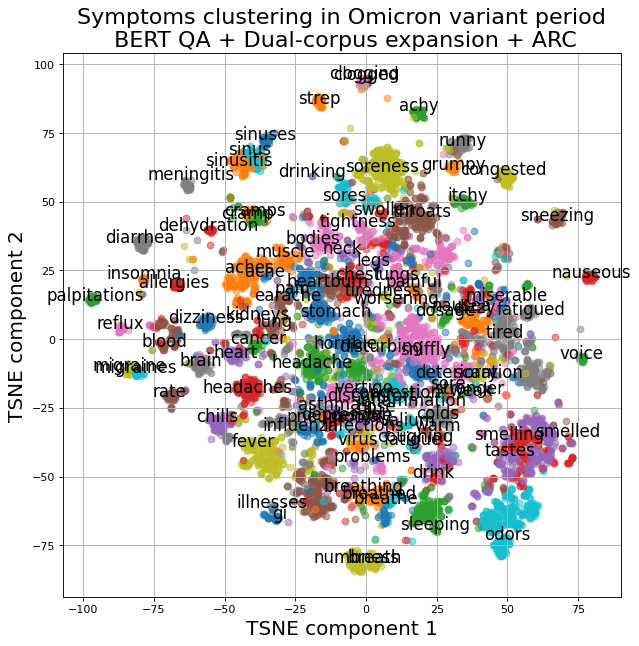

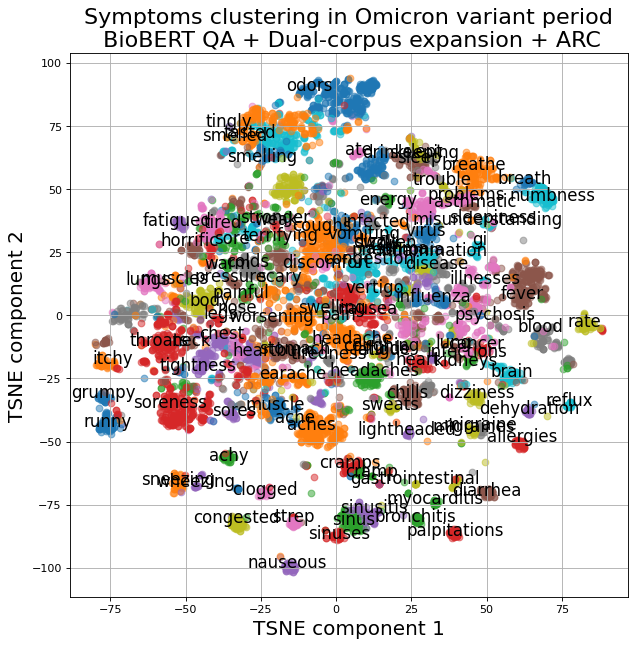

In [11]:
figure(figsize=(9, 9), dpi=80)
TSNE_Visualization(sym2vec_dic_BERTlarge, iter_dic_BERTlarge, plotname ='Symptoms clustering in Omicron variant period\n BERT QA + Dual-corpus expansion + ARC', freq=20)
figure(figsize=(9, 9), dpi=80)
TSNE_Visualization(sym2vec_dic_BioBERTlarge, iter_dic_BioBERTlarge, plotname ='Symptoms clustering in Omicron variant period\n BioBERT QA + Dual-corpus expansion + ARC', freq=20)


### Assign UMLS symptom directly

In [237]:
ULMS_mapping_sym_BERTlarge2020 = np.load('./output_files/ULMS_mapping_sym_BERTlarge.npy',allow_pickle='TRUE').item()['ULMS_mapping_sym_BERTlarge']
ULMS_mapping_sym_BioBERTlarge2020 = np.load('./output_files/ULMS_mapping_sym_BioBERTlarge.npy',allow_pickle='TRUE').item()['ULMS_mapping_sym_BioBERTlarge']


In [238]:
ULMS_mapping_sym_BERTlarge = {} 
for k,v in iter_dic_BERTlarge.items():
    for k2020, v2020 in ULMS_mapping_sym_BERTlarge2020.items():
        if k == k2020[1:]:
            ULMS_mapping_sym_BERTlarge[k2020] = v + [v2020[-1]]
            break
ULMS_mapping_sym_BioBERTlarge = {} 
for k,v in iter_dic_BioBERTlarge.items():
    for k2020, v2020 in ULMS_mapping_sym_BioBERTlarge2020.items():
        if k == k2020[1:]:
            ULMS_mapping_sym_BioBERTlarge[k2020] = v + [v2020[-1]]
            break

######################  Or use UMLS mapping (not good): ######################

### Read UMLS dictionary

In [20]:
# import re
# symptom_synonyms_dic = np.load('./symptom_synonyms.npy',allow_pickle='TRUE').item()
# symptom_synonyms_dic = dict((k.lower(), v) for k, v in symptom_synonyms_dic.items())  #make keys lowers
# symptom_synonyms_dic = dict((k, [vi.lower() for vi in v]) for k, v in symptom_synonyms_dic.items()) #make values lowers
# symptom_synonyms_dic = dict((k, [k]+v) for k, v in symptom_synonyms_dic.items())      #key also in values
# symptom_synonyms_dic_words = dict((k, set(re.findall(r"[\w']+", ' '.join(v)))) for k, v in symptom_synonyms_dic.items()) #make values' word


### Make UMLS dictionary smaller

In [ ]:
# print("original UMLS dictionary has", len(symptom_synonyms_dic), "items")

# symptom_synonyms_basic_dic = {}
# for k, vs in symptom_synonyms_dic.items():
#     symptom_synonyms_basic_dic_keywords_set = set(re.findall(r"[\w']+", ' '.join(vs)))
#     if (sym_key_query_BERTlarge.union(sym_key_query_BioBERTlarge)-{'no','not'}).intersection(symptom_synonyms_basic_dic_keywords_set) != set():
#         symptom_synonyms_basic_dic[k] = vs
#     else:
#         continue
# print("smaller UMLS dictionary has", len(symptom_synonyms_basic_dic), "items")



### UMLS map

In [17]:
# %run './py_func/UMLS_mapping_method.py'

In [109]:
# #<prevent running>
# ULMS_mapping_sym_BERTlarge = UMLS_mapping_method(iter_dic_BERTlarge,UMLS_basic_dic=symptom_synonyms_basic_dic)
# ULMS_mapping_sym_BioBERTlarge = UMLS_mapping_method(iter_dic_BioBERTlarge, UMLS_basic_dic = symptom_synonyms_basic_dic)

In [31]:
# #np.save('./output_files/2021Dec2022Mar/ULMS_mapping_sym_BERTlarge.npy', {'ULMS_mapping_sym_BERTlarge':ULMS_mapping_sym_BERTlarge}) 
# #np.save('./output_files/2021Dec2022Mar/ULMS_mapping_sym_BioBERTlarge.npy', {'ULMS_mapping_sym_BioBERTlarge':ULMS_mapping_sym_BioBERTlarge}) 
# ULMS_mapping_sym_BERTlarge = np.load('./output_files/2021Dec2022Mar/ULMS_mapping_sym_BERTlarge.npy',allow_pickle='TRUE').item()['ULMS_mapping_sym_BERTlarge']
# ULMS_mapping_sym_BioBERTlarge = np.load('./output_files/2021Dec2022Mar/ULMS_mapping_sym_BioBERTlarge.npy',allow_pickle='TRUE').item()['ULMS_mapping_sym_BioBERTlarge']

######################  Over  ######################

### Map original symptoms to standard names

In [239]:
standard_sym_per_body_BioBERTlarge =  []
for i in range(len(gathered_sym_per_body_BioBERTlarge)):
    standard_sym_per_body_BioBERTlarge.append([])
    for j in gathered_sym_per_body_BioBERTlarge[i]:
        for k,v in ULMS_mapping_sym_BioBERTlarge.items():
            if j in v:
                standard_sym_per_body_BioBERTlarge[i].append(v[-1][0])

standard_sym_per_body_BERTlarge =  []
for i in range(len(gathered_sym_per_body_BERTlarge)):
    standard_sym_per_body_BERTlarge.append([])
    for j in gathered_sym_per_body_BERTlarge[i]:
        for k,v in ULMS_mapping_sym_BERTlarge.items():
            if j in v:
                standard_sym_per_body_BERTlarge[i].append(v[-1][0])

###  Get time-based symptoms

In [240]:
timebased_syms_Omicron_BERTlarge = pd.DataFrame() #record for later using to create positive dataframe
timebased_syms_Omicron_BERTlarge['author'] = ori_Int_Ans_content_id_BERTlarge
timebased_syms_Omicron_BERTlarge['time'] = ori_Int_Ans_time_id_BERTlarge
timebased_syms_Omicron_BERTlarge['symptoms'] = standard_sym_per_body_BERTlarge
# timebased_syms_Omicron_BERTlarge.to_csv('./output_files/2021Dec2022Mar/timebased_syms_Omicron_BERTlarge.csv',index=False, encoding='utf_8_sig')

timebased_syms_Omicron_BioBERTlarge = pd.DataFrame() #record for later using to create positive dataframe
timebased_syms_Omicron_BioBERTlarge['author'] = ori_Int_Ans_content_id_BioBERTlarge
timebased_syms_Omicron_BioBERTlarge['time'] = ori_Int_Ans_time_id_BioBERTlarge
timebased_syms_Omicron_BioBERTlarge['symptoms'] = standard_sym_per_body_BioBERTlarge
# timebased_syms_Omicron_BioBERTlarge.to_csv('./output_files/2021Dec2022Mar/timebased_syms_Omicron_BioBERTlarge.csv',index=False, encoding='utf_8_sig')


In [241]:
## load 
timebased_syms_Omicron_BERTlarge = pd.read_csv('./output_files/2021Dec2022Mar/timebased_syms_Omicron_BERTlarge.csv')
timebased_syms_Omicron_BioBERTlarge = pd.read_csv('./output_files/2021Dec2022Mar/timebased_syms_Omicron_BioBERTlarge.csv')
timebased_syms_Omicron_BioBERTlarge

,author,time,symptoms
0,-01101101-,2022-01-18 00:42:47,['blood']
1,-1911-,2022-01-21 21:31:15,"['smell', 'smell', 'smell', 'body']"
2,-1911-,2022-01-24 21:21:15,[]
3,-Boy-Mom,2021-12-22 03:36:39,"['nose', 'stops breathing']"
4,-CryptoSardine-,2022-01-01 23:26:51,"['sweating symptom', 'aches', 'fever', 'trouble']"
...,...,...,...
26853,zzcczzcc,2022-01-16 01:19:50,"['smell', 'congestion', 'whisky']"
26854,zzcczzcc,2022-01-16 13:35:52,"['smell', 'nasal congestion', 'stops breathing..."
26855,zzcczzcc,2022-01-18 00:37:13,[]
26856,zzcczzcc,2022-01-20 06:01:47,['sleep']


### Count (by post)

In [242]:
print('--------------- BERT --------------- ')
count_list = [item for sublist in standard_sym_per_body_BERTlarge for item in list(set(sublist))]
count_list = [i for i in count_list if i!=' ']  #remove ' ' 
from collections import Counter
Counter(count_list).most_common()
symptom_freq_dataframe = pd.DataFrame.from_dict(Counter(count_list), orient='index').reset_index()
symptom_freq_dataframe = symptom_freq_dataframe.rename(columns={0: "count_freq"})
print(symptom_freq_dataframe.sort_values(by='count_freq', ascending=False).head(20))
# symptom_freq_dataframe.to_csv('./output_files/2021Dec2022Mar/Freq_by_post_BERT.csv', index=False)

print('--------------- BioBERT --------------- ')
count_list = [item for sublist in standard_sym_per_body_BioBERTlarge for item in list(set(sublist))]
count_list = [i for i in count_list if i!=' ']  #remove ' ' 
from collections import Counter
Counter(count_list).most_common()
symptom_freq_dataframe = pd.DataFrame.from_dict(Counter(count_list), orient='index').reset_index()
symptom_freq_dataframe = symptom_freq_dataframe.rename(columns={0: "count_freq"})
print(symptom_freq_dataframe.sort_values(by='count_freq', ascending=False).head(20))
# symptom_freq_dataframe.to_csv('./output_files/2021Dec2022Mar/Freq_by_post_BioBERT.csv', index=False)



--------------- BERT --------------- 
                     index  count_freq
15     sore throat symptom        3131
14                coughing        2672
11                headache        1854
5                    fever        1798
20                    pain        1344
65          lack of energy        1239
68                   aches        1189
43  loss of sense of smell        1119
27              congestion        1041
21                   chill         700
19             common cold         698
44                  nausea         662
8                    sleep         651
25        chest discomfort         607
16                   runny         575
3                     nose         501
12                   awful         491
28                   tired         479
48            stomach ache         466
85               dizziness         456
--------------- BioBERT --------------- 
                     index  count_freq
19     sore throat symptom        3255
17                coughi

### Count (by user)

In [243]:
print('Total number of positive users:', len(set(positive_data2021Dec2022Mar['author'])))

user_id_BERTlarge = np.load('./output_files/2021Dec2022Mar/Int_Ans_BERTlarge_and_ID.npy',allow_pickle='TRUE').item()['ori_Int_Ans_content_id_BERTlarge']
count_dic_BERTlarge = {} 
for i in range(len(user_id_BERTlarge)):
    if user_id_BERTlarge[i] not in count_dic_BERTlarge: 
        count_dic_BERTlarge[user_id_BERTlarge[i]] = set()
        count_dic_BERTlarge[user_id_BERTlarge[i]] = count_dic_BERTlarge[user_id_BERTlarge[i]].union(set(standard_sym_per_body_BERTlarge[i]))
    else:
        count_dic_BERTlarge[user_id_BERTlarge[i]] = count_dic_BERTlarge[user_id_BERTlarge[i]].union(set(standard_sym_per_body_BERTlarge[i]))
count_dic_BERTlarge = {k:v for k,v in count_dic_BERTlarge.items() if v!=set()}
print('NLP BERT: there are %d'%(len(count_dic_BERTlarge)), 'authors have been extracted COVID symptoms' ) 
print('On average, each author reported %f unique symptoms' %np.mean([len(v) for k,v in count_dic_BERTlarge.items()]))



user_id_BioBERTlarge = np.load('./output_files/2021Dec2022Mar/Int_Ans_BioBERTlarge_and_ID.npy',allow_pickle='TRUE').item()['ori_Int_Ans_content_id_BioBERTlarge']
count_dic_BioBERTlarge = {}
for i in range(len(user_id_BioBERTlarge)):
    if user_id_BioBERTlarge[i] not in count_dic_BioBERTlarge: 
        count_dic_BioBERTlarge[user_id_BioBERTlarge[i]] = set()
        count_dic_BioBERTlarge[user_id_BioBERTlarge[i]] = count_dic_BioBERTlarge[user_id_BioBERTlarge[i]].union(set(standard_sym_per_body_BioBERTlarge[i]))
    else:
        count_dic_BioBERTlarge[user_id_BioBERTlarge[i]] = count_dic_BioBERTlarge[user_id_BioBERTlarge[i]].union(set(standard_sym_per_body_BioBERTlarge[i]))
count_dic_BioBERTlarge = {k:v for k,v in count_dic_BioBERTlarge.items() if v!=set()}
print('NLP BioBERT: there are %d'%(len(count_dic_BioBERTlarge)), 'authors have been extracted COVID symptoms' ) 
print('On average, each author reported %f unique symptoms' %np.mean([len(v) for k,v in count_dic_BioBERTlarge.items()]))


Total number of positive users: 12094
NLP BERT: there are 7080 authors have been extracted COVID symptoms
On average, each author reported 4.115960 unique symptoms
NLP BioBERT: there are 7573 authors have been extracted COVID symptoms
On average, each author reported 4.307408 unique symptoms


In [245]:
print('--------------- BERT --------------- ')
count_list = [item for ks,vs in count_dic_BERTlarge.items() for item in list(vs)]
count_list = [i for i in count_list if i !=' ']  #remove ' ' 

from collections import Counter
Counter(count_list).most_common()
symptom_freq_dataframe = pd.DataFrame.from_dict(Counter(count_list), orient='index').reset_index()
symptom_freq_dataframe = symptom_freq_dataframe.rename(columns={0: "count_freq"})
symptom_freq_dataframe['freq'] = round(symptom_freq_dataframe['count_freq']/len(count_dic_BERTlarge),3)
print(symptom_freq_dataframe.sort_values(by='count_freq', ascending=False).head(20))
# symptom_freq_dataframe.to_csv('./output_files/2021Dec2022Mar/Freq_by_user_BERT.csv', index=False)

print('--------------- BioBERT --------------- ')
count_list = [item for ks,vs in count_dic_BioBERTlarge.items() for item in list(vs)]
count_list = [i for i in count_list if i !=' ']  #remove ' ' 

from collections import Counter
Counter(count_list).most_common()
symptom_freq_dataframe = pd.DataFrame.from_dict(Counter(count_list), orient='index').reset_index()
symptom_freq_dataframe = symptom_freq_dataframe.rename(columns={0: "count_freq"})
symptom_freq_dataframe['freq'] = round(symptom_freq_dataframe['count_freq']/len(count_dic_BioBERTlarge),3)
print(symptom_freq_dataframe.sort_values(by='count_freq', ascending=False).head(20))
# symptom_freq_dataframe.to_csv('./output_files/2021Dec2022Mar/Freq_by_user_BioBERT.csv', index=False)


--------------- BERT --------------- 
                     index  count_freq   freq
15     sore throat symptom        2164  0.306
14                coughing        1886  0.266
10                headache        1406  0.199
6                    fever        1379  0.195
20                    pain        1044  0.147
65          lack of energy         991  0.140
68                   aches         968  0.137
43  loss of sense of smell         856  0.121
27              congestion         805  0.114
17             common cold         599  0.085
21                   chill         575  0.081
11                   sleep         535  0.076
16                   runny         490  0.069
25        chest discomfort         464  0.066
40                  nausea         463  0.065
12                   awful         429  0.061
3                     nose         427  0.060
28                   tired         410  0.058
13  sore sensation quality         388  0.055
61            stomach ache         370  0.